# Importando bibliotecas

In [6]:
import numpy as np
import pandas as pd
from datetime import datetime as dt
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from math import sqrt
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from arch.unitroot import PhillipsPerron as pp
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.simplefilter('ignore')
%matplotlib inline
sns.set_style("whitegrid")
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)

# 1. Importando base de dados formatada

## 1.1 Tratando os dados internos

In [7]:
dt_parse = lambda dates: dt.strptime(dates, '%Y-%m-%d')

data = pd.read_csv('data/transformed/2000_2021_Brazilian_Northeast_Region_daily_MW_instantaneous_maximum_demand_series.csv',
                   header=0, names=['index','value', 'date'], parse_dates=True, index_col='index', date_parser=dt_parse)
data['value'] = data['value'].astype(float)
data['date'] = data['date'].astype('datetime64')
data = data[data['value'] > 0.0]
data.head()

,value,date
index,,
2000-01-01,6205.0,2000-01-01
2000-01-02,6797.0,2000-01-02
2000-01-03,7024.0,2000-01-03
2000-01-04,6921.0,2000-01-04
2000-01-05,7025.0,2000-01-05


# 2. ARIMA

## 2.1 Tratando os dados internos

In [8]:
split_date = '1/1/2018 12:00:00 AM'
test  = data[split_date : ]
train = data[ : split_date]

train = train['value']
test = test['value']
series = pd.concat([train, test], axis=0)

series

index
2000-01-01     6205.000
2000-01-02     6797.000
2000-01-03     7024.000
2000-01-04     6921.000
2000-01-05     7025.000
                ...    
2021-01-27    12308.892
2021-01-28    12550.095
2021-01-29    12413.574
2021-01-30    11988.032
2021-01-31    11540.266
Name: value, Length: 7702, dtype: float64

## 2.2 Métodos para treinamento

In [9]:
# Plot the forecasts in the context of the original dataset
def plot_forecasts(series, forecasts, test):
	# f1 = pyplot.figure()
	# Plot the entire dataset in blue
	plt.plot(series)
	# Plot the forecasts in red
	for i in range(len(forecasts)):
        # Start offset for x-axis
		off_s = len(series) - len(test) + i - 1
        # End offset for x-axis
		off_e = off_s + len(forecasts[i]) + 1
        # Indexes of x-axis for multi-step forecasts
		xaxis = [x for x in range(off_s, off_e)]
        # Values of muti-step fotecasts
		yaxis = [series[off_s]] + forecasts[i]
		plt.plot(xaxis, yaxis, color='red')
	# Show the final plot
	# f1.savefig("figure.png", bbox_inches='tight', dpi=600)
	plt.show()

# Save predictions, expected and errors
def save_results_file(test, forecasts, n_steps):
	predictions = {}
	expected = {}
	erros = {}
	for i in range(n_steps):
		# Picking the values from multi-step forecasts
		ypred_ts = [forecast[i] for forecast in forecasts]
		# Store predictions
		predictions['t+' + str(i+1)] = ypred_ts
        # Save as an object
		# with open('ypred_ts.txt', 'wb') as fp:
			# pickle.dump(ypred_ts, fp)
        # Sliding window on test set
		ytrue_ts = test[i:len(ypred_ts)+i]
        # Convert to list
		ytrue_ts_lst = [i for i in ytrue_ts]
		# Store expected
		expected['t+' + str(i+1)] = ytrue_ts_lst
		# Calculate erro
		erro = sqrt(mean_squared_error(ytrue_ts, ypred_ts))
		# Store erro
		erros['t+' + str(i+1)] = erro
    # Save predictions to file
	with open('data/retrain/daily_demand_predictions_arima.txt', 'w') as output:
		for k, v in predictions.items():
			output.write(str(k)+'\n')
			output.write(str(v)+'\n')
    # Save expected to file
	with open('data/retrain/daily_demand_expected_arima.txt', 'w') as output:
		for k, v in expected.items():
			output.write(str(k)+'\n')
			output.write(str(v)+'\n')
    # Save expected to file
	with open('data/retrain/daily_demand_errors_arima.txt', 'w') as output:
		for k, v in erros.items():
			output.write(str(k)+'\n')
			output.write(str(v)+'\n')

# Evaluate the RMSE for each forecast time step
def evaluate_forecasts(test, forecasts, n_steps):
	for i in range(n_steps):
		# Picking the values from multi-step forecasts
		ypred_ts = [forecast[i] for forecast in forecasts]
		# Sliding window on test set
		ytrue_ts = test[i:len(ypred_ts)+i]
		print('t+%d RMSE: %f | MAPE: %f' % ((i+1), sqrt(mean_squared_error(ytrue_ts, ypred_ts)),
                                            mean_absolute_percentage_error(ytrue_ts, ypred_ts)*100))

# Multi-step ARIMA's forecast
def arima_forecast(train, config, n_steps):
    # Umpack configs
	p, d, q = config
	# Define model
	model = ARIMA(train, order=(p,d,q), trend=None, trend_offset=1)
	# Fit model
	model_fit = model.fit()
	# print(model_fit.summary())
	# Make the multi-step forecast
	yhat = model_fit.predict(len(train), len(train)+n_steps-1)
    # Convert the numpy-array like forecasts to list structure
	yhat_list = [value for value in yhat]
	return yhat_list

## 2.3 Treinamento e resultado

t+1 RMSE: 428.497368 | MAPE: 2.954985
t+2 RMSE: 490.299349 | MAPE: 3.382380
t+3 RMSE: 504.020377 | MAPE: 3.461854


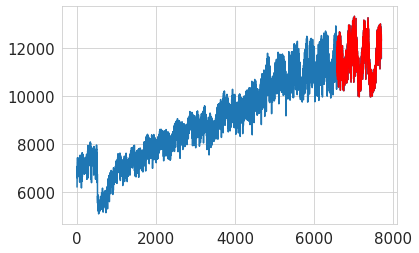

In [10]:
test = test.values
series = series.values
train = [x for x in train]
# Number of multi-step
n_steps = 3
# ARIMA configs
p_param = 1
d_param = 1
q_param = 1  # 1, 0
config = [p_param, d_param, q_param]
# Store multi-step forecasts
forecasts = list()
# Number of multi-step forecasts
n_forecasts = len(test) - n_steps + 1

for i in range(n_forecasts):
	# Make a multi-step forecast
	try:
		yhat = arima_forecast(train, config, n_steps)
	except:
		continue
    # Store the multi-step forecast
	forecasts.append(yhat)
	# Add actual observation to train for the next loop
	obs = test[i]
	train.append(obs)
# Save predictions, expected and errors
save_results_file(test, forecasts, n_steps)
# Evaluate the forecasts
evaluate_forecasts(test, forecasts, n_steps)
# Plot the forecasts
plot_forecasts(series, forecasts, test)